## Number of evaluations (i.e., of different seeds)

In [1]:
nb_seed = 10

## Functions to save results in csv format per method

In [2]:
def write_rs_fd_grr(values):
        with open('results/acs/final_results_rs_fd_grr.csv', mode='a', newline='') as scores_file:
            scores_writer = csv.writer(scores_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            scores_writer.writerow(values)
        scores_file.close()
        
def write_rs_fd_sue_r(values):
        with open('results/acs/final_results_rs_fd_sue_r.csv', mode='a', newline='') as scores_file:
            scores_writer = csv.writer(scores_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            scores_writer.writerow(values)
        scores_file.close()
        
def write_rs_fd_oue_r(values):
        with open('results/acs/final_results_rs_fd_oue_r.csv', mode='a', newline='') as scores_file:
            scores_writer = csv.writer(scores_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            scores_writer.writerow(values)
        scores_file.close()

def write_rs_rfd_grr(values):
        with open('results/acs/final_results_rs_rfd_grr.csv', mode='a', newline='') as scores_file:
            scores_writer = csv.writer(scores_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            scores_writer.writerow(values)
        scores_file.close()

def write_rs_rfd_sue_r(values):
        with open('results/acs/final_results_rs_rfd_sue_r.csv', mode='a', newline='') as scores_file:
            scores_writer = csv.writer(scores_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            scores_writer.writerow(values)
        scores_file.close()

def write_rs_rfd_oue_r(values):
        with open('results/acs/final_results_rs_rfd_oue_r.csv', mode='a', newline='') as scores_file:
            scores_writer = csv.writer(scores_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            scores_writer.writerow(values)
        scores_file.close()        

## Numba library for speeding up things

In [ ]:
from numba import jit

## GRR functions

In [4]:
@jit(nopython=True)
def GRR(x, lst_val, p, q):
    """
    GRR mechanism
    input: true value x, domain values 'lst_val', and probabilities p,q
    output: true value w.p. 'p', random value (except x) w.p. 'q'
    """
    
    rnd = np.random.random()

    if rnd <=p:    
        return x
    else:
        return np.random.choice(lst_val[lst_val !=x]) 

## UE functions

In [5]:
@jit(nopython=True)
def UE(arr, p, q):
    """
    UE mechanism
    input: encoded true value arr and probabilities p and q
    output: sanitized array 'rep'
    """
    
    size = len(arr) #domain size
    rep = np.zeros(size) # initialize zero-vector
    
    for ind in range(size): # for each bit
        if arr[ind] != 1:
            rnd = np.random.random()
            if rnd <= q:
                rep[ind] = 1       
        else:
            rnd = np.random.random()
            if rnd <= p:
                rep[ind] = 1
    return rep

## Main libraries

In [6]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd; pd.set_option('mode.chained_assignment',None)
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import copy
import datetime
import time
import csv
from pandas.core.common import flatten

from diffprivlib.mechanisms import Laplace

## Import estimators

In [7]:
from estimators import SB_RSpFD_GRR, SB_RSpFD_UE, SB_RSpRFD_GRR, SB_RSpRFD_UE_r

## Reading dataset

In [8]:
df = pd.read_csv('db_ACSEmployement.csv')
df

,AGEP,SCHL,MAR,SEX,DIS,ESP,MIG,CIT,MIL,ANC,NATIVITY,RELP,DEAR,DEYE,DREM,RAC1P,GCL,ESR
0,61,16.0,3,1,2,-99999.0,1.0,1,4.0,1,1,16,2,2,2.0,1,2.0,6.0
1,57,17.0,3,1,1,-99999.0,3.0,1,4.0,1,1,16,2,2,1.0,1,2.0,6.0
2,18,19.0,5,2,2,-99999.0,3.0,1,4.0,2,1,17,2,2,2.0,1,-99999.0,6.0
3,28,14.0,3,1,1,-99999.0,1.0,1,2.0,1,1,16,2,2,1.0,1,-99999.0,6.0
4,18,16.0,5,2,1,-99999.0,3.0,1,4.0,2,1,17,2,1,2.0,9,-99999.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10331,15,13.0,5,2,2,-99999.0,1.0,1,-99999.0,2,1,7,2,2,2.0,1,-99999.0,-99999.0
10332,65,18.0,5,1,2,-99999.0,1.0,1,4.0,1,1,0,2,2,2.0,3,2.0,3.0
10333,46,21.0,1,1,2,-99999.0,1.0,1,4.0,1,1,0,2,2,2.0,1,2.0,1.0
10334,46,16.0,1,2,2,-99999.0,1.0,1,4.0,1,1,1,2,2,2.0,1,2.0,1.0


## Dataset to work with

In [10]:
attributes = list(df.columns)

LE = LabelEncoder()

for col in attributes:
    df[col] = LE.fit_transform(df[col])
df

,AGEP,SCHL,MAR,SEX,DIS,ESP,MIG,CIT,MIL,ANC,NATIVITY,RELP,DEAR,DEYE,DREM,RAC1P,GCL,ESR
0,61,16,2,0,1,0,1,0,4,0,0,16,1,1,2,0,2,5
1,57,17,2,0,0,0,3,0,4,0,0,16,1,1,1,0,2,5
2,18,19,4,1,1,0,3,0,4,1,0,17,1,1,2,0,0,5
3,28,14,2,0,0,0,1,0,2,0,0,16,1,1,1,0,0,5
4,18,16,4,1,0,0,3,0,4,1,0,17,1,0,2,8,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10331,15,13,4,1,1,0,1,0,0,1,0,7,1,1,2,0,0,0
10332,65,18,4,0,1,0,1,0,4,0,0,0,1,1,2,2,2,3
10333,46,21,0,0,1,0,1,0,4,0,0,0,1,1,2,0,2,1
10334,46,16,0,1,1,0,1,0,4,0,0,1,1,1,2,0,2,1


## Static parameters

In [11]:
#number of dimensions (d)
d = len(attributes)
print('d=', d)

#number of users (n)
n = df.shape[0]
print('n=',n)

#sampling rate
beta = 1/d
print('beta=', beta)

#range of epsilon used in experiments
lst_eps = [round(np.log(val), 4) for val in range(2,8)]
print('epsilon=', lst_eps)

d= 18
n= 10336
beta= 0.05555555555555555
epsilon= [0.6931, 1.0986, 1.3863, 1.6094, 1.7918, 1.9459]


## Real frequency

In [12]:
# For each attribute, count the number of people per value

dic_true = {att:{val:0 for val in np.unique(df[att])} for att in attributes}

for att in attributes:

    dfcp = df.groupby(att).count()
    n = df.shape[0]

    index = 0
    for val in dfcp.index:
        val_true = dfcp.values[index,0]
        dic_true[att][val] += val_true 
        index+=1
dic_true

{'AGEP': {0: 89,
  1: 83,
  2: 108,
  3: 105,
  4: 108,
  5: 120,
  6: 111,
  7: 124,
  8: 121,
  9: 141,
  10: 132,
  11: 132,
  12: 111,
  13: 131,
  14: 125,
  15: 122,
  16: 122,
  17: 127,
  18: 131,
  19: 118,
  20: 101,
  21: 83,
  22: 92,
  23: 86,
  24: 108,
  25: 84,
  26: 123,
  27: 98,
  28: 94,
  29: 109,
  30: 128,
  31: 132,
  32: 96,
  33: 91,
  34: 130,
  35: 109,
  36: 117,
  37: 118,
  38: 95,
  39: 109,
  40: 119,
  41: 103,
  42: 105,
  43: 92,
  44: 104,
  45: 88,
  46: 93,
  47: 122,
  48: 114,
  49: 107,
  50: 94,
  51: 110,
  52: 114,
  53: 125,
  54: 148,
  55: 144,
  56: 156,
  57: 158,
  58: 196,
  59: 194,
  60: 199,
  61: 175,
  62: 205,
  63: 180,
  64: 171,
  65: 191,
  66: 187,
  67: 169,
  68: 161,
  69: 144,
  70: 168,
  71: 138,
  72: 122,
  73: 111,
  74: 102,
  75: 97,
  76: 114,
  77: 77,
  78: 77,
  79: 78,
  80: 73,
  81: 55,
  82: 53,
  83: 51,
  84: 38,
  85: 39,
  86: 36,
  87: 40,
  88: 22,
  89: 23,
  90: 23,
  91: 67},
 'SCHL': {0: 280,
  

## RS+FD[GRR]

In [13]:
starttime = time.time()

#run experiments 'nb_seed' times
for seed in range(nb_seed):
    print(seed)
    
    np.random.seed(seed)

    dic_rsfd_grr = {} # initialize dictionary to save MSE result per epsilon

    for epsilon_tot in lst_eps: #iterate over each epsilon value

        eps_l = np.log((np.exp(epsilon_tot) - 1 + beta)/beta) #amplification by sampling
        
        # we'll shuffle the users' order in the dataset
        dff = df.sample(frac=1)     
        dff.reset_index(drop=True, inplace=True)
        
        # we'll partitionate the users indexes to separate in groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(dff.index, d)]

        lst_mse_att = [] # given epsilon, initialize a list to save MSE result per attribute

        for index_att in range(d): # for each attribute

            att = attributes[index_att]

            lst_val = np.unique(list(dic_true[att].keys())) # take domain values of the attribute
            
            k = len(lst_val)  # domain size of the attribute
            
            # select users that report the true value of this attribute (i.e., not fake data)
            lst_true = list(dff.iloc[lst_index[index_att]][att])
            
            # GRR parameters with amplified epsilon (eps_l)
            p = np.exp(eps_l) / (np.exp(eps_l) + k - 1) 
            q = (1 - p) / (k - 1)
            
            # list with epsilon-LDP values
            lst_grr = [GRR(val, lst_val, p, q) for val in lst_true]
            
            # number of fake reports = total number of users - number of users that reported this attribute
            nb_fake = n - len(lst_true)

            lst_fake = [np.random.randint(k) for _ in range(nb_fake)] # uniform fake data on domain k

            total_reports = lst_grr + lst_fake # list of all reports for this attribute (LDP + fake)
            
            #estimated frequency of values for this attribute
            est_rs_fd = SB_RSpFD_GRR(total_reports, p, q, lst_val, d, k, n)
            
            #real frequency of values for this attribute
            real = np.array(list(dic_true[att].values()))
            real = real / sum(real)
            
            #save MSE for this attribute
            lst_mse_att.append(mean_squared_error(real, est_rs_fd))
        
        #for each epsilon, we average the MSE by the number of attributes d (cf. Eq. (13) in the paper)
        dic_rsfd_grr[epsilon_tot] = np.mean(lst_mse_att)
    
    #write results in csv format as: seed, MSE_eps1, MSE_eps2, MSE_eps3, MSE_eps4, MSE_eps5, MSE_eps6
    write_rs_fd_grr(list(flatten([seed, list(dic_rsfd_grr.values())])))
    
print('That took {} seconds'.format(time.time() - starttime))    

0
1
2
3
4
5
6
7
8
9
That took 26.828242540359497 seconds


## RS+FD[SUE-R]

In [14]:
starttime = time.time()

#run experiments 'nb_seed' times
for seed in range(nb_seed):
    print(seed)
    
    np.random.seed(seed)
    
    # initialize dictionary to save MSE result per epsilon
    dic_rsfd_oue_r = {} 

    for epsilon_tot in lst_eps: #iterate over each epsilon value
        
        eps_l = np.log((np.exp(epsilon_tot) - 1 + beta)/beta) #amplification by sampling

        # we'll shuffle the users' order in the dataset
        dff = df.sample(frac=1)    
        dff.reset_index(drop=True, inplace=True)
        
        # we'll partitionate the users indexes to separate in groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(dff.index, d)]
        
        # given epsilon, initialize a list to save MSE result per attribute
        lst_mse_att = []

        for index_att in range(d): # for each attribute

            att = attributes[index_att]

            lst_val = np.unique(list(dic_true[att].keys())) # take domain values of the attribute

            k = len(lst_val) # domain size of the attribute
            
            #Unary encoding
            lst_eye = np.eye(k)
            #initialize a dictionary with an image of each value encoded
            lst_val = {val:0 for val in np.unique(df[att])}
            idx=0
            for key in lst_val.keys():
                lst_val[key] = lst_eye[idx]
                idx+=1

            # select users that report the true value of this attribute (i.e., not fake data)
            lst_true = list(dff.iloc[lst_index[index_att]][att])
            
            # OUE parameters with amplified epsilon (eps_l)
            p = np.exp(eps_l/2) / (np.exp(eps_l/2) + 1)
            q = 1 / (np.exp(eps_l/2) + 1)
            
            # list with epsilon-LDP values
            lst_oue = [UE(lst_val[val], p, q) for val in lst_true]
            
            # number of fake reports = total number of users - number of users that reported this attribute
            nb_fake = n - len(lst_true)
            
            #apply OUE to encoded uniform fake data on domain k
            lst_dummy = [UE(lst_val[np.random.randint(k)], p, q) for _ in range(nb_fake)]

            total_reports = lst_oue + lst_dummy # list of all reports for this attribute (LDP + fake)
            
            #estimated frequency of values for this attribute
            est_rs_fd = SB_RSpFD_UE(total_reports, p, q, d, k, n)

            #real frequency of values for this attribute
            real = np.array(list(dic_true[att].values()))
            real = real / sum(real)

            #save MSE for this attribute
            lst_mse_att.append(mean_squared_error(real, est_rs_fd))
        
        #for each epsilon, we average the MSE by the number of attributes d (cf. Eq. (13) in the paper)
        dic_rsfd_oue_r[epsilon_tot] =  np.mean(lst_mse_att)
    
    #write results in csv format as: seed, MSE_eps1, MSE_eps2, MSE_eps3, MSE_eps4, MSE_eps5, MSE_eps6
    write_rs_fd_sue_r(list(flatten([seed, list(dic_rsfd_oue_r.values())])))
        
print('That took {} seconds'.format(time.time() - starttime))    

0
1
2
3
4
5
6
7
8
9
That took 46.72663617134094 seconds


## RS+FD[OUE-R]

In [15]:
starttime = time.time()

#run experiments 'nb_seed' times
for seed in range(nb_seed):
    print(seed)
    
    np.random.seed(seed)
    
    # initialize dictionary to save MSE result per epsilon
    dic_rsfd_oue_r = {} 

    for epsilon_tot in lst_eps: #iterate over each epsilon value
        
        eps_l = np.log((np.exp(epsilon_tot) - 1 + beta)/beta) #amplification by sampling

        # we'll shuffle the users' order in the dataset
        dff = df.sample(frac=1)    
        dff.reset_index(drop=True, inplace=True)
        
        # we'll partitionate the users indexes to separate in groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(dff.index, d)]
        
        # given epsilon, initialize a list to save MSE result per attribute
        lst_mse_att = []

        for index_att in range(d): # for each attribute

            att = attributes[index_att]

            lst_val = np.unique(list(dic_true[att].keys())) # take domain values of the attribute

            k = len(lst_val) # domain size of the attribute
            
            #Unary encoding
            lst_eye = np.eye(k)
            #initialize a dictionary with an image of each value encoded
            lst_val = {val:0 for val in np.unique(df[att])}
            idx=0
            for key in lst_val.keys():
                lst_val[key] = lst_eye[idx]
                idx+=1

            # select users that report the true value of this attribute (i.e., not fake data)
            lst_true = list(dff.iloc[lst_index[index_att]][att])
            
            # OUE parameters with amplified epsilon (eps_l)
            p = 1/2 
            q = 1 / (np.exp(eps_l) + 1)
            
            # list with epsilon-LDP values
            lst_oue = [UE(lst_val[val], p, q) for val in lst_true]
            
            # number of fake reports = total number of users - number of users that reported this attribute
            nb_fake = n - len(lst_true)
            
            #apply OUE to encoded uniform fake data on domain k
            lst_dummy = [UE(lst_val[np.random.randint(k)], p, q) for _ in range(nb_fake)]

            total_reports = lst_oue + lst_dummy # list of all reports for this attribute (LDP + fake)
            
            #estimated frequency of values for this attribute
            est_rs_fd = SB_RSpFD_UE(total_reports, p, q, d, k, n)

            #real frequency of values for this attribute
            real = np.array(list(dic_true[att].values()))
            real = real / sum(real)

            #save MSE for this attribute
            lst_mse_att.append(mean_squared_error(real, est_rs_fd))
        
        #for each epsilon, we average the MSE by the number of attributes d (cf. Eq. (13) in the paper)
        dic_rsfd_oue_r[epsilon_tot] =  np.mean(lst_mse_att)
    
    #write results in csv format as: seed, MSE_eps1, MSE_eps2, MSE_eps3, MSE_eps4, MSE_eps5, MSE_eps6
    write_rs_fd_oue_r(list(flatten([seed, list(dic_rsfd_oue_r.values())])))
        
print('That took {} seconds'.format(time.time() - starttime))    

0
1
2
3
4
5
6
7
8
9
That took 47.169774770736694 seconds


## RS+RFD[GRR]

In [16]:
starttime = time.time()

#run experiments 'nb_seed' times
for seed in range(nb_seed):
    print(seed)
    
    np.random.seed(seed)

    dic_rsfd_grr = {} # initialize dictionary to save MSE result per epsilon
    
    freq_prior = []
    
    LAP_MECH = Laplace(epsilon=0.1/d, sensitivity=1)

    for att in attributes:
        freq = np.array([int(np.rint(LAP_MECH.randomise(val)).clip(0)) for val in dic_true[att].values()])
        freq = freq/sum(freq) # census de l'annee derniere

        freq_prior.append(freq)

    for epsilon_tot in lst_eps: #iterate over each epsilon value

        eps_l = np.log((np.exp(epsilon_tot) - 1 + beta)/beta) #amplification by sampling
        
        # we'll shuffle the users' order in the dataset
        dff = df.sample(frac=1)     
        dff.reset_index(drop=True, inplace=True)
        
        # we'll partitionate the users indexes to separate in groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(dff.index, d)]

        lst_mse_att = [] # given epsilon, initialize a list to save MSE result per attribute

        for index_att in range(d): # for each attribute

            att = attributes[index_att]

            lst_val = np.unique(list(dic_true[att].keys())) # take domain values of the attribute
            
            k = len(lst_val)  # domain size of the attribute
            
            # select users that report the true value of this attribute (i.e., not fake data)
            lst_true = list(dff.iloc[lst_index[index_att]][att])
            
            # GRR parameters with amplified epsilon (eps_l)
            p = np.exp(eps_l) / (np.exp(eps_l) + k - 1) 
            q = (1 - p) / (k - 1)
            
            # list with epsilon-LDP values
            lst_grr = [GRR(val, lst_val, p, q) for val in lst_true]
            
            # number of fake reports = total number of users - number of users that reported this attribute
            nb_fake = n - len(lst_true)

            lst_fake = [np.random.choice(lst_val, p=freq_prior[index_att]) for _ in range(nb_fake)] # realistic fake data on domain k

            total_reports = lst_grr + lst_fake # list of all reports for this attribute (LDP + fake)
            
            #estimated frequency of values for this attribute
            est_rs_fd = SB_RSpRFD_GRR(total_reports, p, q, lst_val, d, freq_prior[index_att], n)
            
            #real frequency of values for this attribute
            real = np.array(list(dic_true[att].values()))
            real = real / sum(real)
            
            #save MSE for this attribute
            lst_mse_att.append(mean_squared_error(real, est_rs_fd))
        
        #for each epsilon, we average the MSE by the number of attributes d (cf. Eq. (13) in the paper)
        dic_rsfd_grr[epsilon_tot] = np.mean(lst_mse_att)
    
    #write results in csv format as: seed, MSE_eps1, MSE_eps2, MSE_eps3, MSE_eps4, MSE_eps5, MSE_eps6
    write_rs_rfd_grr(list(flatten([seed, list(dic_rsfd_grr.values())])))
    
print('That took {} seconds'.format(time.time() - starttime))    

0
1
2
3
4
5
6
7
8
9
That took 201.28170037269592 seconds


## RS+RFD[SUE-R]

In [17]:
starttime = time.time()

#run experiments 'nb_seed' times
for seed in range(nb_seed):
    print(seed)
    
    np.random.seed(seed)
    
    # initialize dictionary to save MSE result per epsilon
    dic_rsfd_oue_r = {} 
    
    freq_prior = []
    
    LAP_MECH = Laplace(epsilon=0.1/d, sensitivity=1)

    for att in attributes:
        freq = np.array([int(np.rint(LAP_MECH.randomise(val)).clip(0)) for val in dic_true[att].values()])
        freq = freq/sum(freq)

        freq_prior.append(freq)

    for epsilon_tot in lst_eps: #iterate over each epsilon value
        
        eps_l = np.log((np.exp(epsilon_tot) - 1 + beta)/beta) #amplification by sampling

        # we'll shuffle the users' order in the dataset
        dff = df.sample(frac=1)    
        dff.reset_index(drop=True, inplace=True)
        
        # we'll partitionate the users indexes to separate in groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(dff.index, d)]
        
        # given epsilon, initialize a list to save MSE result per attribute
        lst_mse_att = []

        for index_att in range(d): # for each attribute

            att = attributes[index_att]

            lst_val = np.unique(list(dic_true[att].keys())) # take domain values of the attribute

            k = len(lst_val) # domain size of the attribute
            
            #Unary encoding
            lst_eye = np.eye(k)

            lst_val = list()#np.array([])
            for idx in range(k):
                lst_val.append(lst_eye[idx]) 

            # select users that report the true value of this attribute (i.e., not fake data)
            lst_true = list(dff.iloc[lst_index[index_att]][att])
            
            # OUE parameters with amplified epsilon (eps_l)
            p = np.exp(eps_l/2) / (np.exp(eps_l/2) + 1)
            q = 1 / (np.exp(eps_l/2) + 1)
            
            # list with epsilon-LDP values
            lst_oue = [UE(lst_val[val], p, q) for val in lst_true]
            
            # number of fake reports = total number of users - number of users that reported this attribute
            nb_fake = n - len(lst_true)
            
            #apply OUE to encoded realistic fake data on domain k   
            lst_dummy = [UE(lst_val[np.random.choice(range(k), p=freq_prior[index_att])], p, q) for _ in range(nb_fake)]

            total_reports = lst_oue + lst_dummy # list of all reports for this attribute (LDP + fake)
            
            #estimated frequency of values for this attribute
            est_rs_fd = SB_RSpRFD_UE_r(total_reports, p, q, d, freq_prior[index_att], n)

            #real frequency of values for this attribute
            real = np.array(list(dic_true[att].values()))
            real = real / sum(real)

            #save MSE for this attribute
            lst_mse_att.append(mean_squared_error(real, est_rs_fd))
        
        #for each epsilon, we average the MSE by the number of attributes d (cf. Eq. (13) in the paper)
        dic_rsfd_oue_r[epsilon_tot] =  np.mean(lst_mse_att)
    
    #write results in csv format as: seed, MSE_eps1, MSE_eps2, MSE_eps3, MSE_eps4, MSE_eps5, MSE_eps6
    write_rs_rfd_sue_r(list(flatten([seed, list(dic_rsfd_oue_r.values())])))
        
print('That took {} seconds'.format(time.time() - starttime))    

0
1
2
3
4
5
6
7
8
9
That took 293.6909816265106 seconds


## RS+RFD[OUE-R]

In [18]:
starttime = time.time()

#run experiments 'nb_seed' times
for seed in range(nb_seed):
    print(seed)
    
    np.random.seed(seed)
    
    # initialize dictionary to save MSE result per epsilon
    dic_rsfd_oue_r = {} 
    
    freq_prior = []
    
    LAP_MECH = Laplace(epsilon=0.1/d, sensitivity=1)

    for att in attributes:
        freq = np.array([int(np.rint(LAP_MECH.randomise(val)).clip(0)) for val in dic_true[att].values()])
        freq = freq/sum(freq)

        freq_prior.append(freq)

    for epsilon_tot in lst_eps: #iterate over each epsilon value
        
        eps_l = np.log((np.exp(epsilon_tot) - 1 + beta)/beta) #amplification by sampling

        # we'll shuffle the users' order in the dataset
        dff = df.sample(frac=1)    
        dff.reset_index(drop=True, inplace=True)
        
        # we'll partitionate the users indexes to separate in groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(dff.index, d)]
        
        # given epsilon, initialize a list to save MSE result per attribute
        lst_mse_att = []

        for index_att in range(d): # for each attribute

            att = attributes[index_att]

            lst_val = np.unique(list(dic_true[att].keys())) # take domain values of the attribute

            k = len(lst_val) # domain size of the attribute
            
            #Unary encoding
            lst_eye = np.eye(k)

            lst_val = list()#np.array([])
            for idx in range(k):
                lst_val.append(lst_eye[idx]) 

            # select users that report the true value of this attribute (i.e., not fake data)
            lst_true = list(dff.iloc[lst_index[index_att]][att])
            
            # OUE parameters with amplified epsilon (eps_l)
            p = 1/2 
            q = 1 / (np.exp(eps_l) + 1)
            
            # list with epsilon-LDP values
            lst_oue = [UE(lst_val[val], p, q) for val in lst_true]
            
            # number of fake reports = total number of users - number of users that reported this attribute
            nb_fake = n - len(lst_true)
            
            #apply OUE to encoded realistic fake data on domain k   
            lst_dummy = [UE(lst_val[np.random.choice(range(k), p=freq_prior[index_att])], p, q) for _ in range(nb_fake)]

            total_reports = lst_oue + lst_dummy # list of all reports for this attribute (LDP + fake)
            
            #estimated frequency of values for this attribute
            est_rs_fd = SB_RSpRFD_UE_r(total_reports, p, q, d, freq_prior[index_att], n)

            #real frequency of values for this attribute
            real = np.array(list(dic_true[att].values()))
            real = real / sum(real)

            #save MSE for this attribute
            lst_mse_att.append(mean_squared_error(real, est_rs_fd))
        
        #for each epsilon, we average the MSE by the number of attributes d (cf. Eq. (13) in the paper)
        dic_rsfd_oue_r[epsilon_tot] =  np.mean(lst_mse_att)
    
    #write results in csv format as: seed, MSE_eps1, MSE_eps2, MSE_eps3, MSE_eps4, MSE_eps5, MSE_eps6
    write_rs_rfd_oue_r(list(flatten([seed, list(dic_rsfd_oue_r.values())])))
        
print('That took {} seconds'.format(time.time() - starttime))    

0
1
2
3
4
5
6
7
8
9
That took 290.5806245803833 seconds


## Results

In [19]:
import warnings; warnings.simplefilter('ignore')
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
params = {'axes.titlesize':'18',
          'xtick.labelsize':'18',
          'ytick.labelsize':'18',
          'font.size':'18',
          'legend.fontsize':'medium',
          'lines.linewidth':'2',
          'font.weight':'normal',
          'lines.markersize':'10'
          }
matplotlib.rcParams.update(params)
plt.rcParams["mathtext.fontset"] = "cm"
# plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [22]:
sample_rate=1
rs_fd_grr = pd.read_csv('results/acs/final_results_rs_fd_grr.csv', header=None, index_col=0).sample(frac=sample_rate)
rs_rfd_grr = pd.read_csv('results/acs/final_results_rs_rfd_grr.csv', header=None, index_col=0).sample(frac=sample_rate)

rs_fd_sue_r = pd.read_csv('results/acs/final_results_rs_fd_sue_r.csv', header=None, index_col=0).sample(frac=sample_rate)
rs_rfd_sue_r = pd.read_csv('results/acs/final_results_rs_rfd_sue_r.csv', header=None, index_col=0).sample(frac=sample_rate)

rs_fd_oue_r = pd.read_csv('results/acs/final_results_rs_fd_oue_r.csv', header=None, index_col=0).sample(frac=sample_rate)
rs_rfd_oue_r = pd.read_csv('results/acs/final_results_rs_rfd_oue_r.csv', header=None, index_col=0).sample(frac=sample_rate)

rs_fd_grr.shape, rs_rfd_grr.shape, rs_fd_sue_r.shape, rs_rfd_sue_r.shape, rs_fd_oue_r.shape, rs_rfd_oue_r.shape

((10, 6), (10, 6), (10, 6), (10, 6), (10, 6), (10, 6))

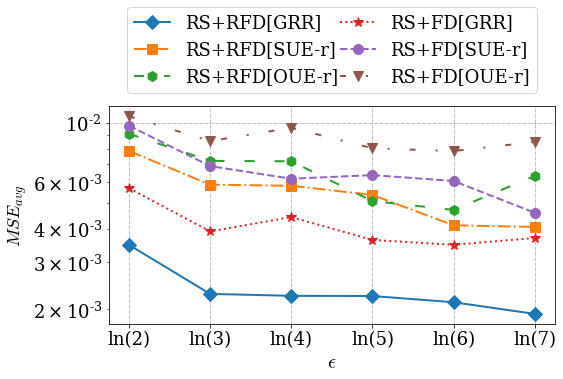

In [23]:
lst_eps = [round(np.log(val), 4) for val in range(2,8)]

plt.figure(figsize=(8,4))

plt.plot(rs_rfd_grr.mean(), label='RS+RFD[GRR]', marker='D')
plt.plot(rs_rfd_sue_r.mean(), label='RS+RFD[SUE-r]', marker='s',linestyle='dashdot')
plt.plot(rs_rfd_oue_r.mean(), label='RS+RFD[OUE-r]', marker='h',linestyle=(0, (5, 10)))

plt.grid(color='grey', linestyle='dashdot', linewidth=0.5)
plt.plot(rs_fd_grr.mean(), label='RS+FD[GRR]', marker='*', linestyle='dotted')
plt.plot(rs_fd_sue_r.mean(), label='RS+FD[SUE-r]', linestyle ='dashed', marker='o')
plt.plot(rs_fd_oue_r.mean(), label='RS+FD[OUE-r]', linestyle =(0, (3, 10, 1, 10)), marker='v')

plt.yscale('log')
plt.xlabel('$\epsilon$', fontsize=20)
plt.ylabel('$MSE_{avg}$')
plt.xticks(range(1,len(lst_eps)+1), ["ln("+str(val)+")" for val in range(2,8)])
plt.legend(ncol=2, columnspacing=0.1, loc='upper center', bbox_to_anchor=(0.5, 1.5));
# plt.savefig("fig_rsprfd_VS_rspfd_acs.pdf", dpi=500, bbox_inches = 'tight',pad_inches = 0.1)
plt.show()